In [1]:
from datetime import datetime
import os
import re

# Get the current directory
current_directory = '/home/andrew/Downloads/Predictions4'

# Regular expression to extract the [name] portion
pattern = r'(\d+)_(.*?)_(.*?)_(.*?)_(\d{2}_\d{2}_\d{4}_\d{2}_\d{2}_\d{2})\.log'

# Create a dictionary to store filenames by [name]
name_to_files = {}

# List all files with a .log extension in the current directory
log_files = [file for file in os.listdir(current_directory) if file.endswith(".log")]


# Function to parse the timestamp string into a datetime object
def parse_timestamp(timestamp_str):
    return datetime.strptime(timestamp_str, '%d_%m_%Y_%H_%M_%S')


# Iterate through log files and group them by [name]
for log_file in log_files:
    match = re.search(pattern, log_file)
    if match:
        name = match.group(4)
        timestamp_str = match.group(5)
        timestamp = parse_timestamp(timestamp_str)

        if name not in name_to_files:
            name_to_files[name] = []
        name_to_files[name].append((timestamp, log_file))

# Print the grouped filenames
for name, files in name_to_files.items():
    print(f"[name]: {name}")
    sorted_files = sorted(files, key=lambda x: x[0])  # Sort by timestamp
    for _timestamp, file in sorted_files:
        print(file)

[name]: VIRAT_S_040001_01_000448_001101_
0_compressed_nofeatures_VIRAT_S_040001_01_000448_001101__01_11_2023_11_45_03.log
0_compressed_features_VIRAT_S_040001_01_000448_001101__01_11_2023_11_53_37.log
3_compressed_nofeatures_VIRAT_S_040001_01_000448_001101__01_11_2023_12_02_37.log
3_compressed_features_VIRAT_S_040001_01_000448_001101__01_11_2023_12_09_23.log
6_compressed_nofeatures_VIRAT_S_040001_01_000448_001101__01_11_2023_12_16_51.log
6_compressed_features_VIRAT_S_040001_01_000448_001101__01_11_2023_12_23_31.log
9_compressed_nofeatures_VIRAT_S_040001_01_000448_001101__01_11_2023_12_30_35.log
9_compressed_features_VIRAT_S_040001_01_000448_001101__01_11_2023_12_37_15.log
[name]: VIRAT_S_040000_01_000042_000099_
0_compressed_nofeatures_VIRAT_S_040000_01_000042_000099__01_11_2023_03_54_37.log
0_compressed_features_VIRAT_S_040000_01_000042_000099__01_11_2023_04_03_15.log
3_compressed_nofeatures_VIRAT_S_040000_01_000042_000099__01_11_2023_04_12_15.log
3_compressed_features_VIRAT_S_040000_

In [5]:
from enum import Enum
import numpy as np


class InputSet:
    def __init__(self, height, width, ):
        self.event_bitrate = None
        self.compressed_bitrate = None
        self.adder_feature_count = None
        self.adder_time = None
        self.cv_feature_count = None
        self.cv_time = None
        self.psnr = None
        self.mse = None
        self.ssim = None
        self.recon_psnr = None
        self.recon_mse = None
        self.recon_ssim = None
        self.precision = None
        self.recall = None
        self.accuracy = None


def process_entry(entry, input_sets):
    if 's' in entry:
        if "OpenCV" in entry['s']:
            input_sets[-1].cv_features[entry['y'], entry['x']] = True
        elif "ADDER" in entry['s']:
            input_sets[-1].adder_features[entry['y'], entry['x']] = True
        else:
            raise Exception("Malformed entry")
    elif 'psnr' in entry:
        input_sets[-1].psnr = entry['psnr']
        input_sets[-1].mse = entry['mse']
        input_sets[-1].ssim = entry['ssim']
        
def process_recon_entry(entry, input_sets, idx):
    if 'psnr' in entry:
        input_sets[idx].recon_psnr = entry['psnr']
        input_sets[idx].recon_mse = entry['mse']
        input_sets[idx].recon_ssim = entry['ssim']


import pickle

Stage = Enum('Stage', ['RAW', 'RECON', 'COMPRESS_SIZE'])

def read_logfile(path):
    objects = []
    with (
            open(
                path,
                "rb")) as openfile:
        # Read the dimensions
        dims = openfile.readline().decode('UTF-8')
        # print(dims)
        width = int(dims.split('x')[0])
        height = int(dims.split('x')[1])
        channels = int(dims.split('x')[2])

        dbg_lines = 0
        input_interval_idx = 0
        input_sets = [InputSet(height, width)]
        recon = False
        input_set_index = 0
        stage = Stage.RAW
        adu_interval = None

        while True:
            try:
                entry = pickle.load(openfile)
                if type(entry) == str and "ADDER FAST:" in entry:
                    # The start of a new interval
                    time = entry.split(': ')[1]
                    input_sets[-1].adder_time = int(time)
                    continue
                elif type(entry) == str and "bps:" in entry:
                    # The bitrate
                    # The end of the interval
                    bitrate = float(entry.split(': ')[1]) / 1024.0 / 1024.0
                    input_sets[-1].event_bitrate = bitrate

                    input_sets += [InputSet(height, width)]
                    input_interval_idx += 1
                    continue
                elif type(entry) == str and "RECONSTRUCTION" in entry:
                    stage = Stage.RECON
                    input_set_index = 0
                elif type(entry) == str and "Compressed adu" in entry:
                    stage = Stage.COMPRESS_SIZE
                    input_set_index = 0
                elif type(entry) == str and "OpenCV FAST:" in entry:
                    time = entry.split(': ')[1]
                    input_sets[-1].cv_time = int(time)

                elif type(entry) == str and "META:" in entry:
                    print(entry)
                    continue
                elif type(entry) == str and "Feature results:" in entry:
                    precision = pickle.load(openfile)
                    input_sets[-1].precision = precision
                    recall = pickle.load(openfile)
                    input_sets[-1].recall = recall
                    accuracy = pickle.load(openfile)
                    input_sets[-1].accuracy = accuracy
                    
                elif type(entry) == int:
                    if stage == stage.RAW:
                        if input_sets[-1].adder_feature_count is None:
                            input_sets[-1].adder_feature_count = entry
                        else:
                            input_sets[-1].cv_feature_count = entry
                    elif stage == stage.COMPRESS_SIZE:
                        for i in range(input_set_index, input_set_index + adu_interval):
                            input_sets[i].compressed_bitrate = (entry * 8) / adu_interval
                        input_set_index += adu_interval
                    else:
                        raise Exception("unexpected int")
                    
                else:
                    if stage == Stage.RAW:
                        process_entry(entry, input_sets)
                    elif stage == Stage.RECON:
                        process_recon_entry(entry, input_sets, input_set_index)
                        input_set_index += 1
                    elif stage == Stage.COMPRESS_SIZE:
                        print('here')
                        break

                    # print(entry)
                    dbg_lines += 1
                    # if dbg_lines == 100000:
                    #     break
            except pickle.UnpicklingError:
                line = openfile.readline().decode('UTF-8')
                if "Ticks per second" in line:
                    tps = int(line.split(': ')[2])
                elif "ticks per source interval" in line:
                    tpf = int(line.split(': ')[2])
                elif "t_max" in line:
                    dt_max = int(line.split(': ')[2])
                    adu_interval = int(dt_max / tpf)
                # break
            except EOFError:
                break

        # Remove the last item because it might have none values
        input_sets = input_sets[:-1]
        if stage == Stage.RAW:
             raise Exception("Did not perform reconstruction!")
        return input_sets, width, height, channels, tps, tpf
    
print(sorted_files[0][1])
input_sets, width, height, channels, tps, tpf = read_logfile(current_directory + '/' + sorted_files[0][1])

print('\nAll done')
print(input_sets[0].recon_psnr)
print(input_sets[0].compressed_bitrate)
print(input_sets[30].compressed_bitrate)

print(sorted_files[1][1])
input_sets, width, height, channels, tps, tpf = read_logfile(current_directory + '/' + sorted_files[1][1])

print('\nAll done')
print(input_sets[0].recon_psnr)
print(input_sets[0].compressed_bitrate)
print(input_sets[30].compressed_bitrate)


0_compressed_nofeatures_VIRAT_S_010110_04_000777_000812__01_11_2023_13_46_28.log

All done
67.45165244232118
887903.4666666667
567807.7333333333
0_compressed_features_VIRAT_S_010110_04_000777_000812__01_11_2023_13_50_07.log


Exception: Did not perform reconstruction!

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import mpld3


def feature_count_plot_all(sets):
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 4))

    for i, input_sets in enumerate(sets):
        adder_feature_count = [obj.adder_feature_count for obj in input_sets]
        cv_feature_count = [obj.cv_feature_count for obj in input_sets]

        sns.lineplot(x=range(len(input_sets) - 1), y=adder_feature_count[:-1], marker=None, label="ADDER_" + str(i))
        sns.lineplot(x=range(len(input_sets) - 1), y=cv_feature_count[:-1], marker=None, label="OpenCV_" + str(i))

    plt.ylabel("# features")
    plt.xlabel("Input frame")
    plt.title("Feature count over time")
    plt.show()
    # interactive_plot = mpld3.display()
    # interactive_plot


def feature_speed_plot_all(sets):
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 4))

    for i, input_sets in enumerate(sets):
        adder_times = [obj.adder_time for obj in input_sets]
        cv_times = [obj.cv_time for obj in input_sets]

        sns.lineplot(x=range(len(input_sets)), y=adder_times, marker=None, label="ADDER_" + str(i))
        sns.lineplot(x=range(len(input_sets)), y=cv_times, marker=None, label="OpenCV_" + str(i))
    plt.ylabel("Time (ns)")
    plt.xlabel("Input frame")
    plt.yscale('log')
    plt.title("Feature detection speed")

    plt.show()
    # interactive_plot = mpld3.display()
    # interactive_plot

    cv_mean = np.mean(np.array(cv_times))
    adder_mean = np.mean(np.array(adder_times))
    percent_change = (adder_mean / cv_mean) - 1
    print('OpenCV mean:', cv_mean, '  Median:', np.median(np.array(cv_times)))
    print('ADDER mean:', adder_mean, "({:.1f}%)".format(percent_change * 100), '  Median:',
          np.median(np.array(adder_times)))


def bitrates_plot_all(sets, width, height, channels, tps, tpf):
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 4))

    for i, input_sets in enumerate(sets):
        adder_bitrates = [obj.event_bitrate for obj in input_sets]

        total_adder_size = np.sum(adder_bitrates) / (tps / tpf)
        print(total_adder_size, "Mb")

        source_raw_Mbps = (width * height * channels * (tps / tpf) * 8.0) / 1024.0 / 1024.0
        total_raw_size = (width * height * channels * len(adder_bitrates) * 8.0) / 1024.0 / 1024.0
        print(total_raw_size, "Mb")
        framed_bitrates = [source_raw_Mbps for obj in input_sets]

        sns.lineplot(x=range(len(input_sets)), y=adder_bitrates, marker=None, label="ADDER_" + str(i))
        sns.lineplot(x=range(len(input_sets)), y=framed_bitrates, marker=None, label="OpenCV_" + str(i))
    plt.ylabel("Raw bitrate (Mb/s)")
    plt.xlabel("Input frame")
    # plt.yscale('log')
    plt.title("Bitrate")

    plt.show()


def quality_plot_all(sets):
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 4))

    for i, input_sets in enumerate(sets):
        adder_psnr = [obj.psnr for obj in input_sets]
        adder_ssim = [obj.ssim for obj in input_sets]

        sns.lineplot(x=range(len(input_sets)), y=adder_psnr, marker=None, label="PSNR_" + str(i))
        sns.lineplot(x=range(len(input_sets)), y=adder_ssim, marker=None, label="SSIM_" + str(i))
    plt.ylabel("Score")
    plt.xlabel("Input frame")
    # plt.yscale('log')
    plt.title("Quality metrics")

    plt.show()

[name]: VIRAT_S_040001_01_000448_001101_


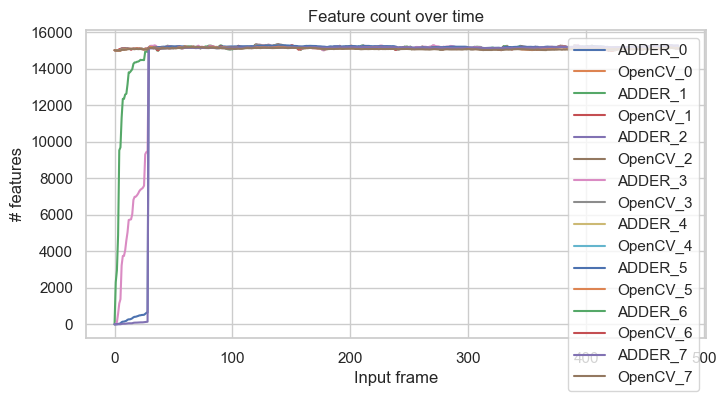

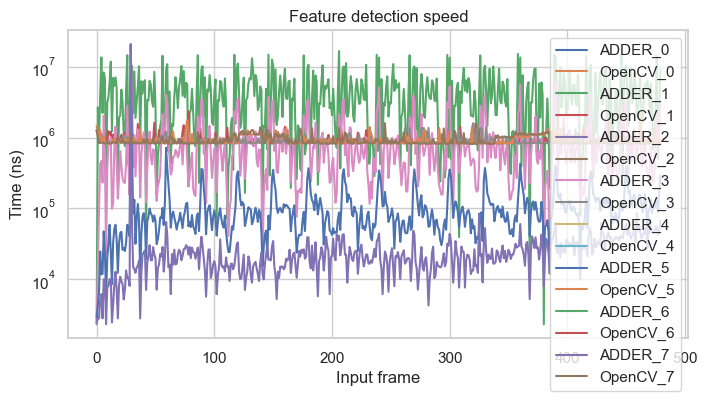

OpenCV mean: 915024.28125   Median: 842393.5
ADDER mean: 66959.5625 (-92.7%)   Median: 21546.5
4719.725601196288 Mb
1898.4375 Mb
4719.725601196288 Mb
1898.4375 Mb
133.2077865600586 Mb
1898.4375 Mb
955.4290466308594 Mb
1898.4375 Mb
45.92772674560547 Mb
1898.4375 Mb
83.1877212524414 Mb
1898.4375 Mb
39.03208923339843 Mb
1898.4375 Mb
41.94662475585937 Mb
1898.4375 Mb


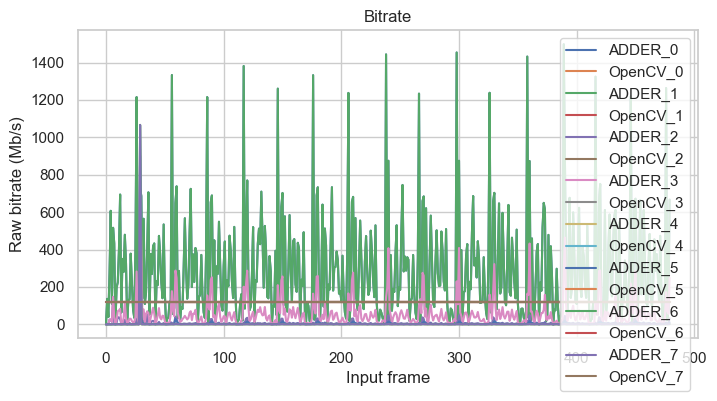

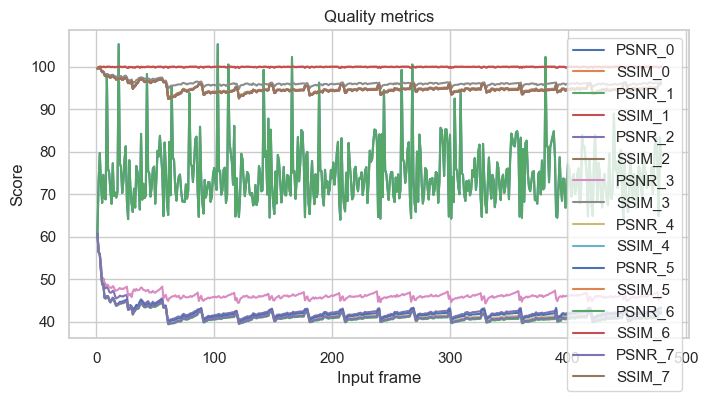

In [16]:
EXPECTED_VIDEO_NUM = 8 # We expect to run 8 permuations: quality 0,3,6,9 both with and without feature detection

for name, files in name_to_files.items():
    print(f"[name]: {name}")
    sorted_files = sorted(files, key=lambda x: x[0])  # Sort by timestamp
    current_input_sets = []
    
    video_count = 0
    for _, file in sorted_files:
        try:
            input_sets, width, height, channels, tps, tpf = read_logfile(current_directory + '/' + file)
            current_input_sets = current_input_sets + [input_sets]
            video_count += 1
        except Exception as e:
            break
    if video_count < 8:
        print("SKIPPING", name)
        continue

    feature_count_plot_all(current_input_sets)
    feature_speed_plot_all(current_input_sets)
    bitrates_plot_all(current_input_sets, width, height, channels, tps, tpf)
    quality_plot_all(current_input_sets)
    break